<a href="https://colab.research.google.com/github/jdhruv1503/summer-of-code-2023/blob/main/machine-learning/week2/ImageRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset selection

Dataset:  Google Open Images Dataset https://storage.googleapis.com/openimages/web/index.html

To begin with, let's import the data and everything else we need:

In [58]:
! pip install boto3
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 38.5 MB/s eta 0:00:00


In [ ]:
# Get Google Open Images Dataset v6 [THIS IS AROUND 2.5GB!!!]

! wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
! wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
! wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv
! wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py

In [47]:
# Extract about 11k useful images from this dataset

import os

id_list = ['/m/01c648', '/m/050k8', '/m/01b7fy'] # laptops, mobile phones, headphones

train_bboxes_filename = os.path.join('.', 'oidv6-train-annotations-bbox.csv')
validation_bboxes_filename = os.path.join('.', 'validation-annotations-bbox.csv')
test_bboxes_filename = os.path.join('.', 'test-annotations-bbox.csv')

image_list_file_path = os.path.join('.', 'image_list_file')

image_list_file_list = []
for j, filename in enumerate([train_bboxes_filename, validation_bboxes_filename, test_bboxes_filename]):
    print(filename)

    with open(filename, 'r') as f:
        line = f.readline()

        while len(line) != 0:

            id, _, class_name, _, x1, x2, y1, y2, _, _, _, _, _ = line.split(',')[:13]

            if class_name in id_list and id not in image_list_file_list:
                image_list_file_list.append(id)

                with open(image_list_file_path, 'a') as fw:
                    fw.write('{}/{}\n'.format(['train', 'validation', 'test'][j], id))

            line = f.readline()

        f.close()

./oidv6-train-annotations-bbox.csv
./validation-annotations-bbox.csv
./test-annotations-bbox.csv


In [48]:
# Download these images (this might take a while)

image_list_file_path = os.path.join('.', 'image_list_file')
with open(image_list_file_path, 'r') as fw:
  for count, line in enumerate(fw):
        pass

print(count, 'images will be downloaded.')


! python downloader.py image_list_file --download_folder=./download

11627 images will be downloaded.


In [55]:
# Create YOLO format data for these images

! rm -rf ./data
! mkdir ./data

import shutil

DATA_ALL_DIR = os.path.join('.', 'download')

DATA_OUT_DIR = os.path.join('.', 'data')

for set_ in ['train', 'validation', 'test']:
    for dir_ in [os.path.join(DATA_OUT_DIR, set_),
                 os.path.join(DATA_OUT_DIR, set_, 'imgs'),
                 os.path.join(DATA_OUT_DIR, set_, 'anns')]:
        if os.path.exists(dir_):
            shutil.rmtree(dir_)
        os.mkdir(dir_)

id_list = ['/m/01c648', '/m/050k8', '/m/01b7fy'] # laptops, mobile phones, headphones

train_bboxes_filename = os.path.join('.', 'oidv6-train-annotations-bbox.csv')
validation_bboxes_filename = os.path.join('.', 'validation-annotations-bbox.csv')
test_bboxes_filename = os.path.join('.', 'test-annotations-bbox.csv')


for j, filename in enumerate([train_bboxes_filename, validation_bboxes_filename, test_bboxes_filename]):
    set_ = ['train', 'validation', 'test'][j]
    print(filename)
    with open(filename, 'r') as f:
        line = f.readline()
        while len(line) != 0:
            id, _, class_name, _, x1, x2, y1, y2, _, _, _, _, _ = line.split(',')[:13]
            if class_name in id_list:
                if not os.path.exists(os.path.join(DATA_OUT_DIR, set_, 'imgs', '{}.jpg'.format(id))):
                    shutil.copy(os.path.join(DATA_ALL_DIR, '{}.jpg'.format(id)),
                                os.path.join(DATA_OUT_DIR, set_, 'imgs', '{}.jpg'.format(id)))

                if class_name == '/m/01c648': id_class=0
                elif class_name == '/m/050k8': id_class=1
                elif class_name == '/m/01b7fy': id_class=2

                with open(os.path.join(DATA_OUT_DIR, set_, 'anns', '{}.txt'.format(id)), 'a') as f_ann:
                    # class_id, xc, yx, w, h
                    x1, x2, y1, y2 = [float(j) for j in [x1, x2, y1, y2]]
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1

                    f_ann.write('{} {} {} {} {}\n'.format(id_class, xc, yc, w, h))
                    f_ann.close()

            line = f.readline()

./oidv6-train-annotations-bbox.csv
./validation-annotations-bbox.csv
./test-annotations-bbox.csv


# Training Ultralytics YOLOv8 Pre-trained Model

In [68]:
! mkdir /content/data/images
! mkdir /content/data/labels

! mkdir /content/data/images/test
! mkdir /content/data/images/train
! mkdir /content/data/images/val

! mkdir /content/data/labels/test
! mkdir /content/data/labels/train
! mkdir /content/data/labels/val

! mv /content/data/test/imgs/* /content/data/images/test/
! mv /content/data/train/imgs/* /content/data/images/train/
! mv /content/data/validation/imgs/* /content/data/images/val/

! mv /content/data/validation/anns/* /content/data/labels/val/
! mv /content/data/test/anns/* /content/data/labels/test/
! mv /content/data/train/anns/* /content/data/labels/train/

In [71]:
# Build a config yaml file and train YOLOv8 on object detection!

from ultralytics import YOLO

model = YOLO("yolov8n.pt")    # Take a pretrained set and train it further

dataset = """
path: /content/data
train: images/train
val: images/val
test: images/test

names:
  0: laptop
  1: phone
  2: headphones
"""

with open("dataset.yaml", "w") as ds:
  ds.write(dataset)

# Train it for about an hour

results = model.train(data="dataset.yaml", epochs=12)

Ultralytics YOLOv8.0.134 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=12, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simpl

# Results!

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/ML_YOLO_12Epochs’: File exists
cp: -r not specified; omitting directory '/content/runs/detect/train/weights'


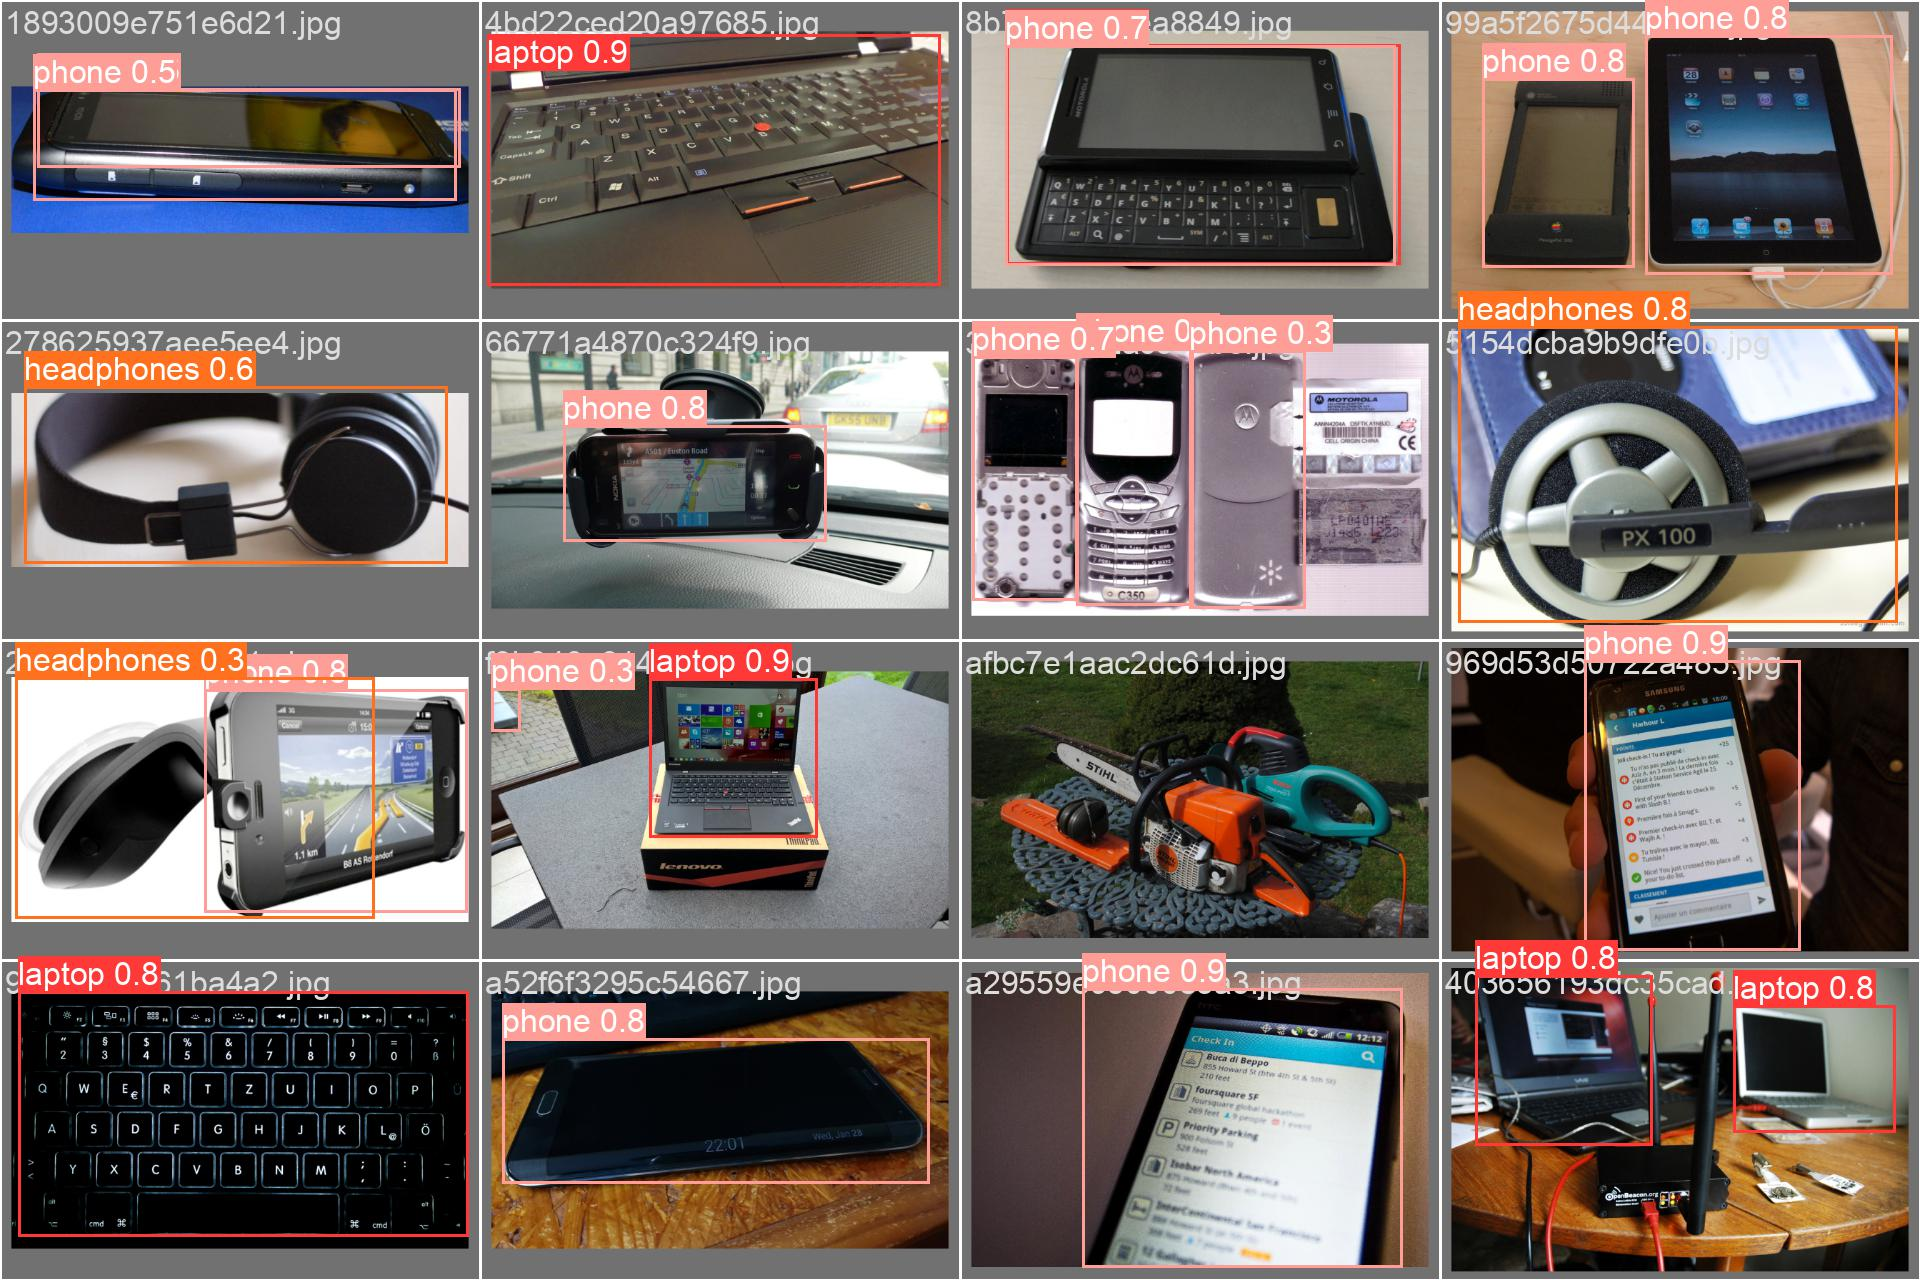

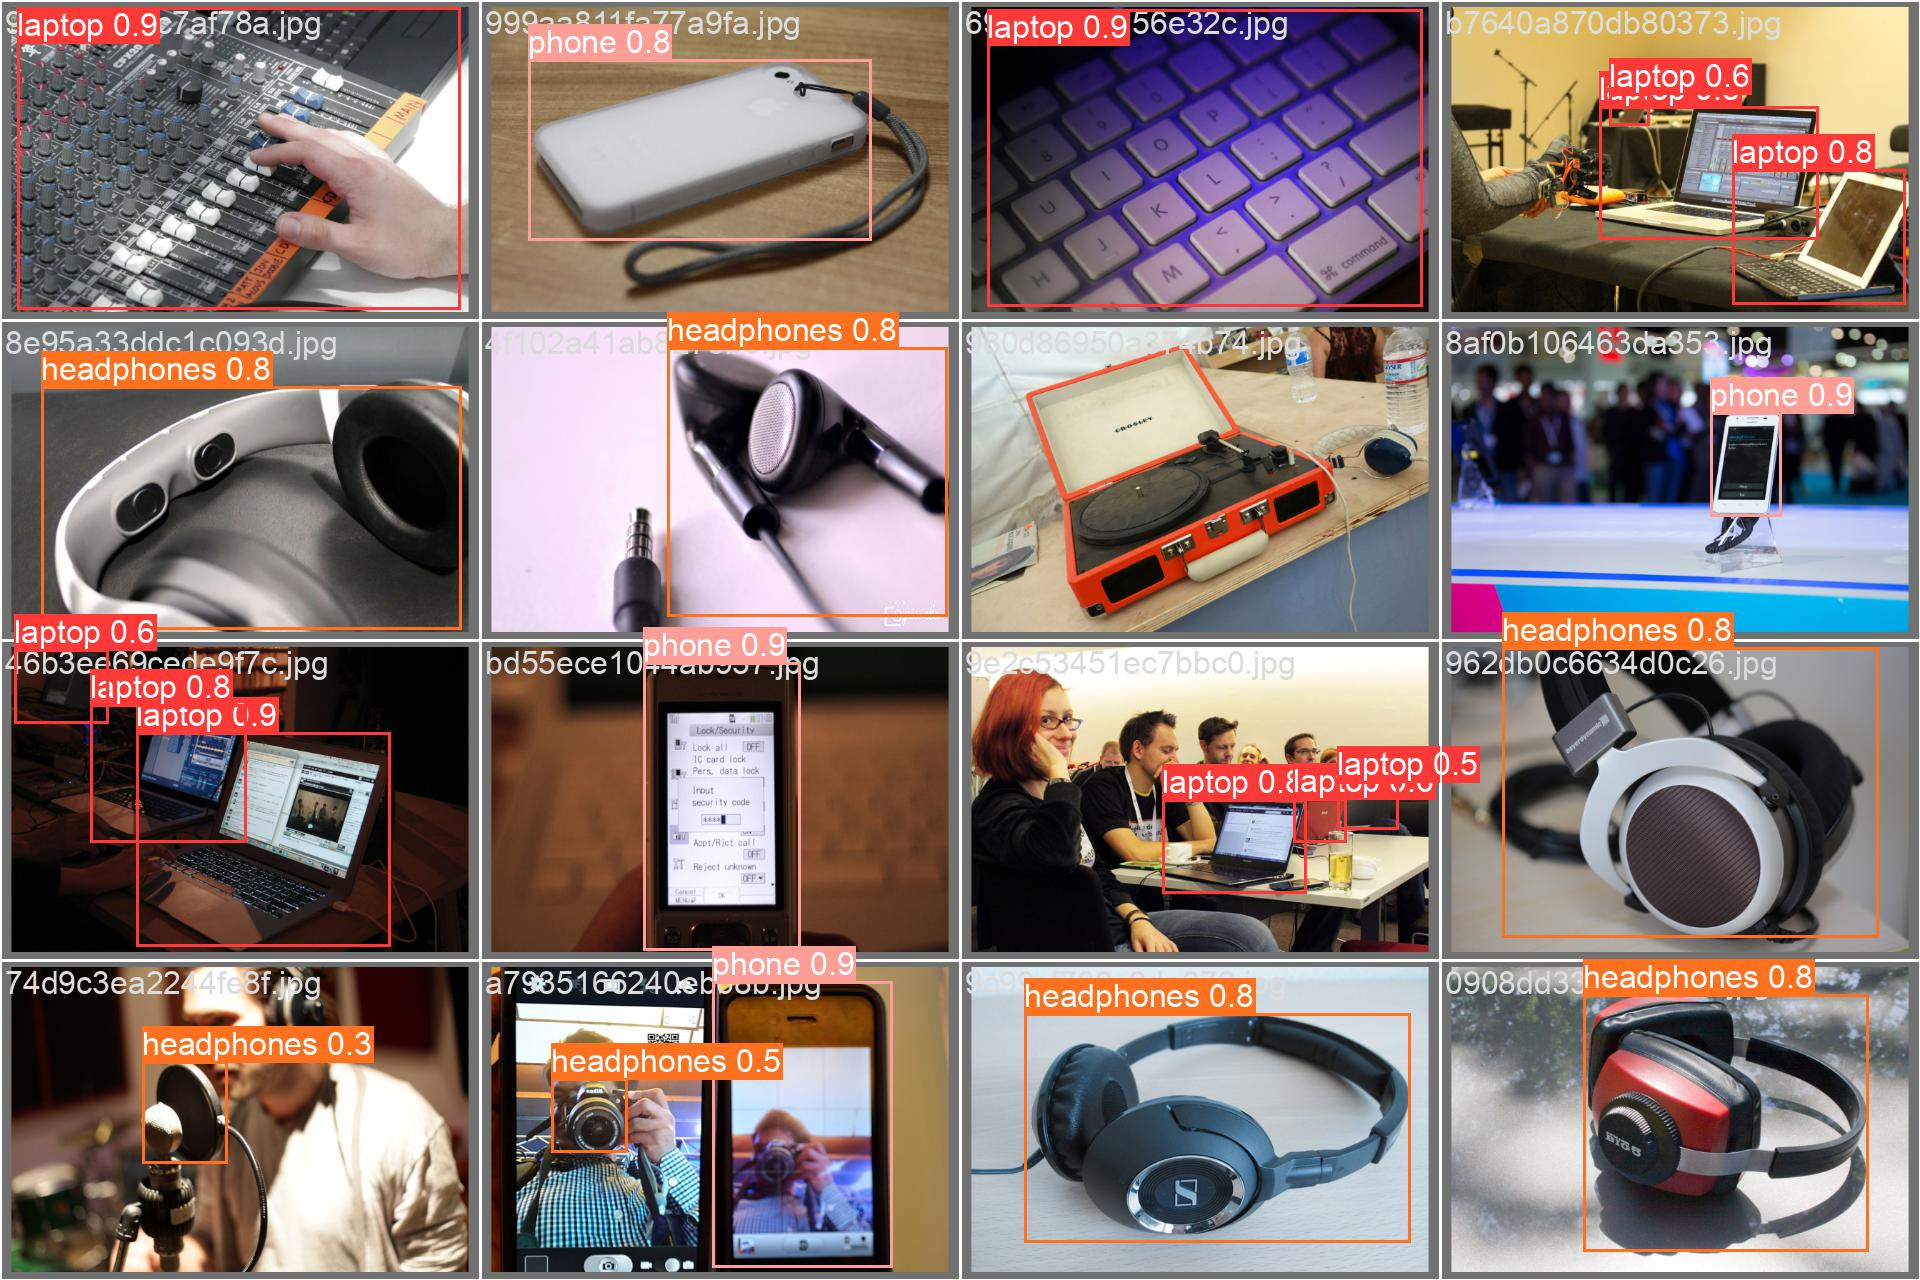

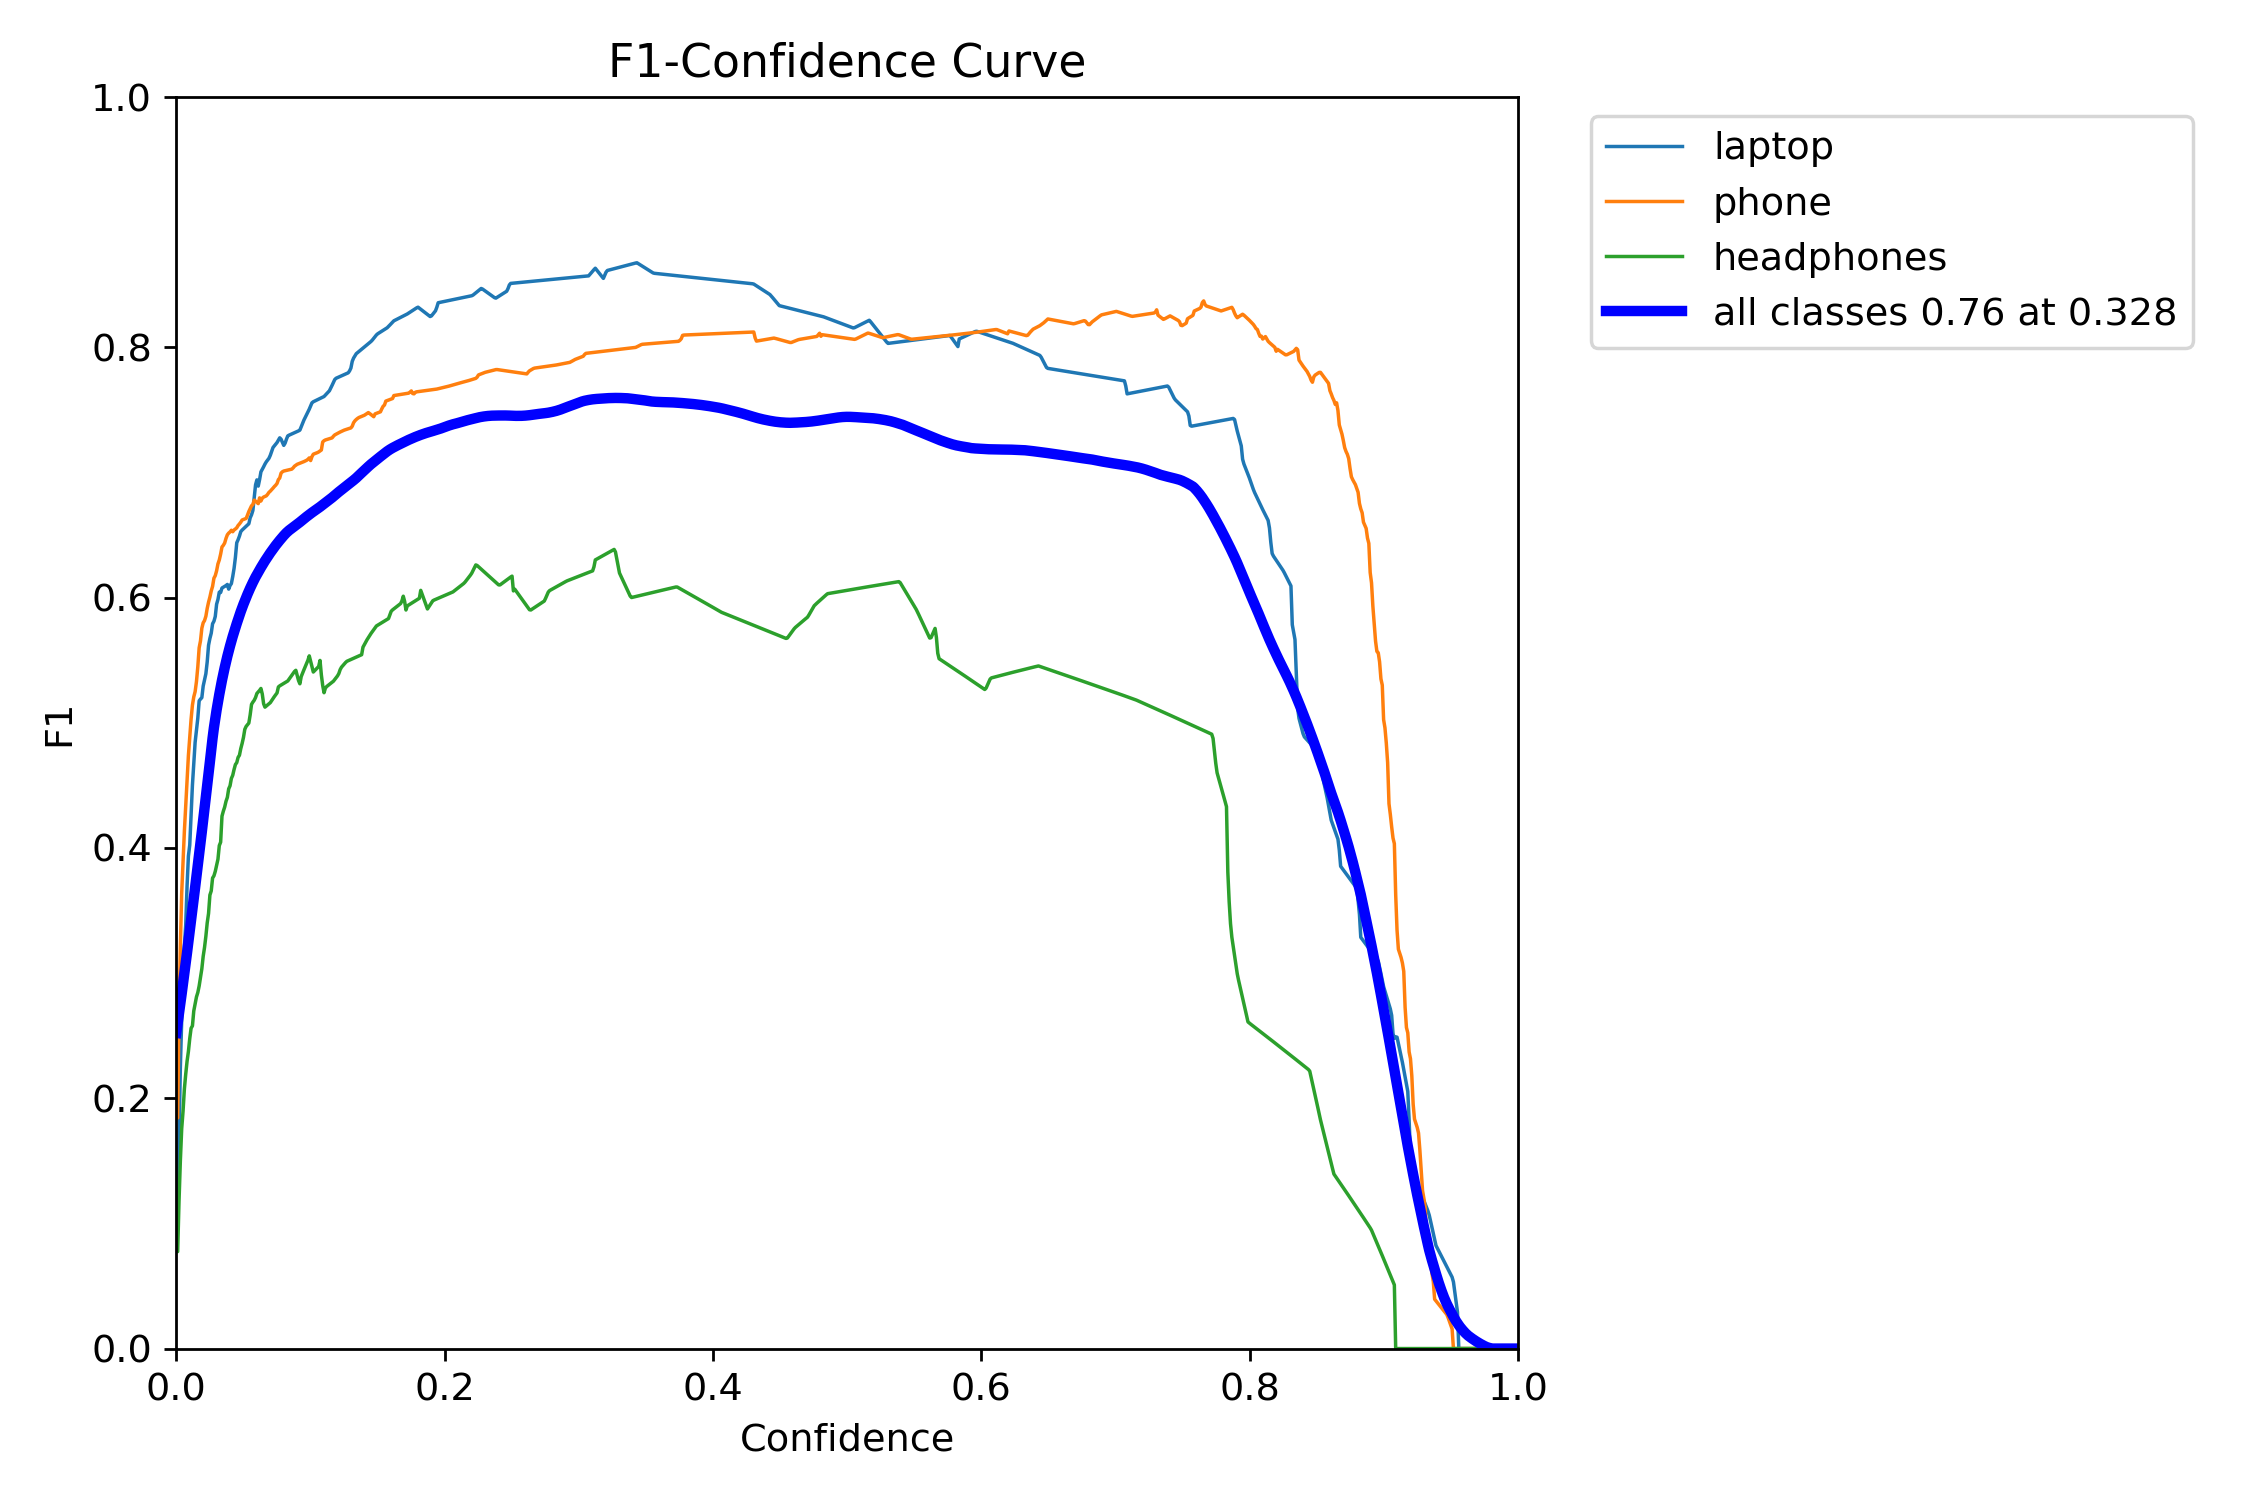

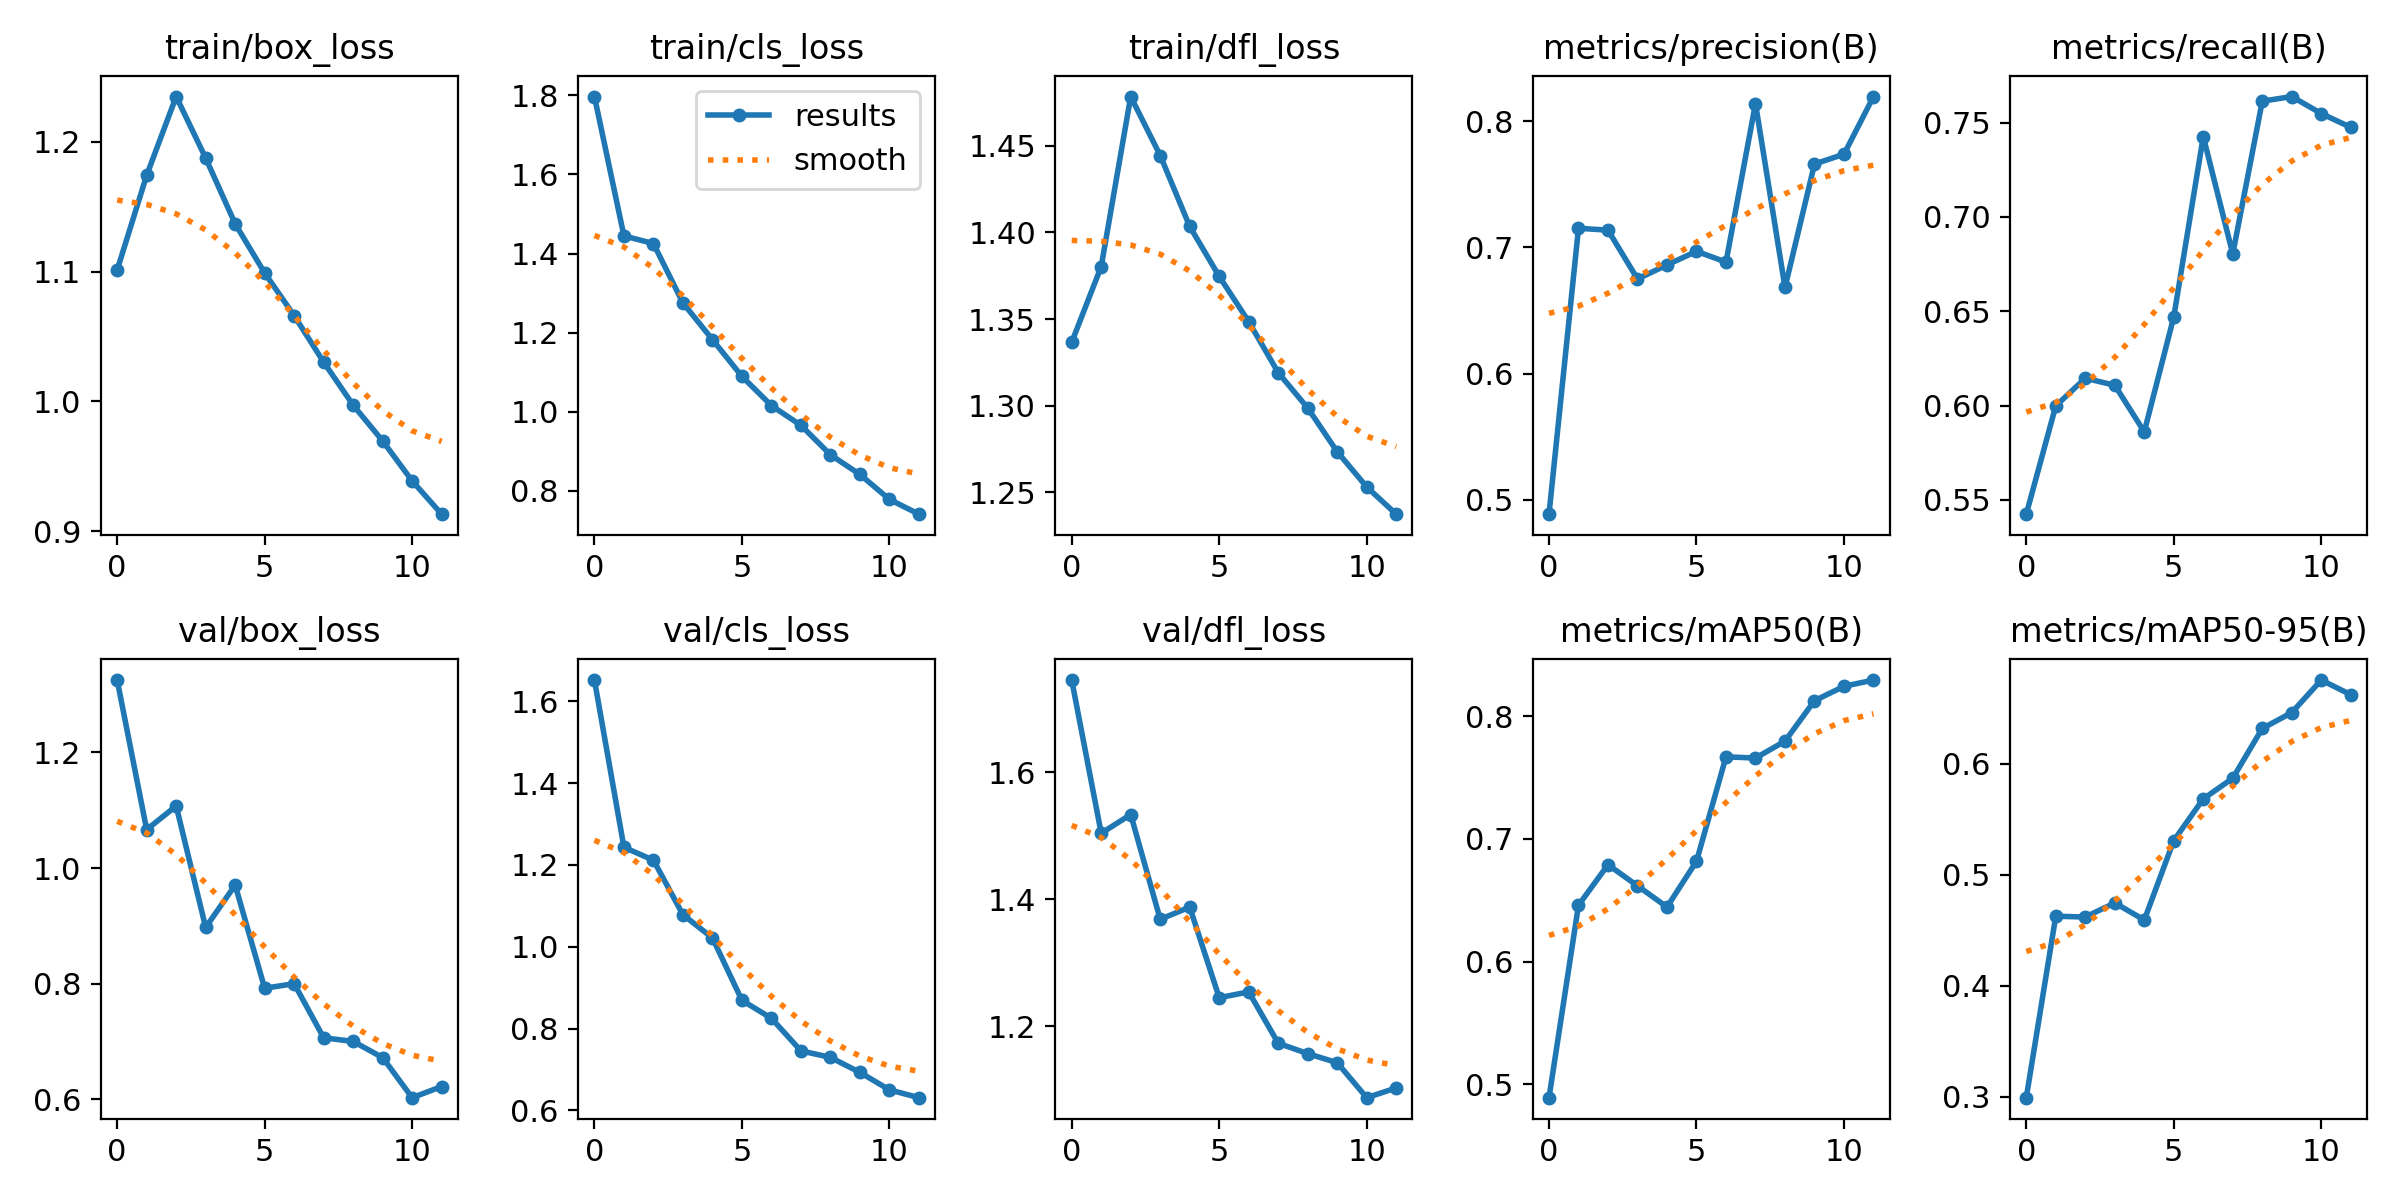

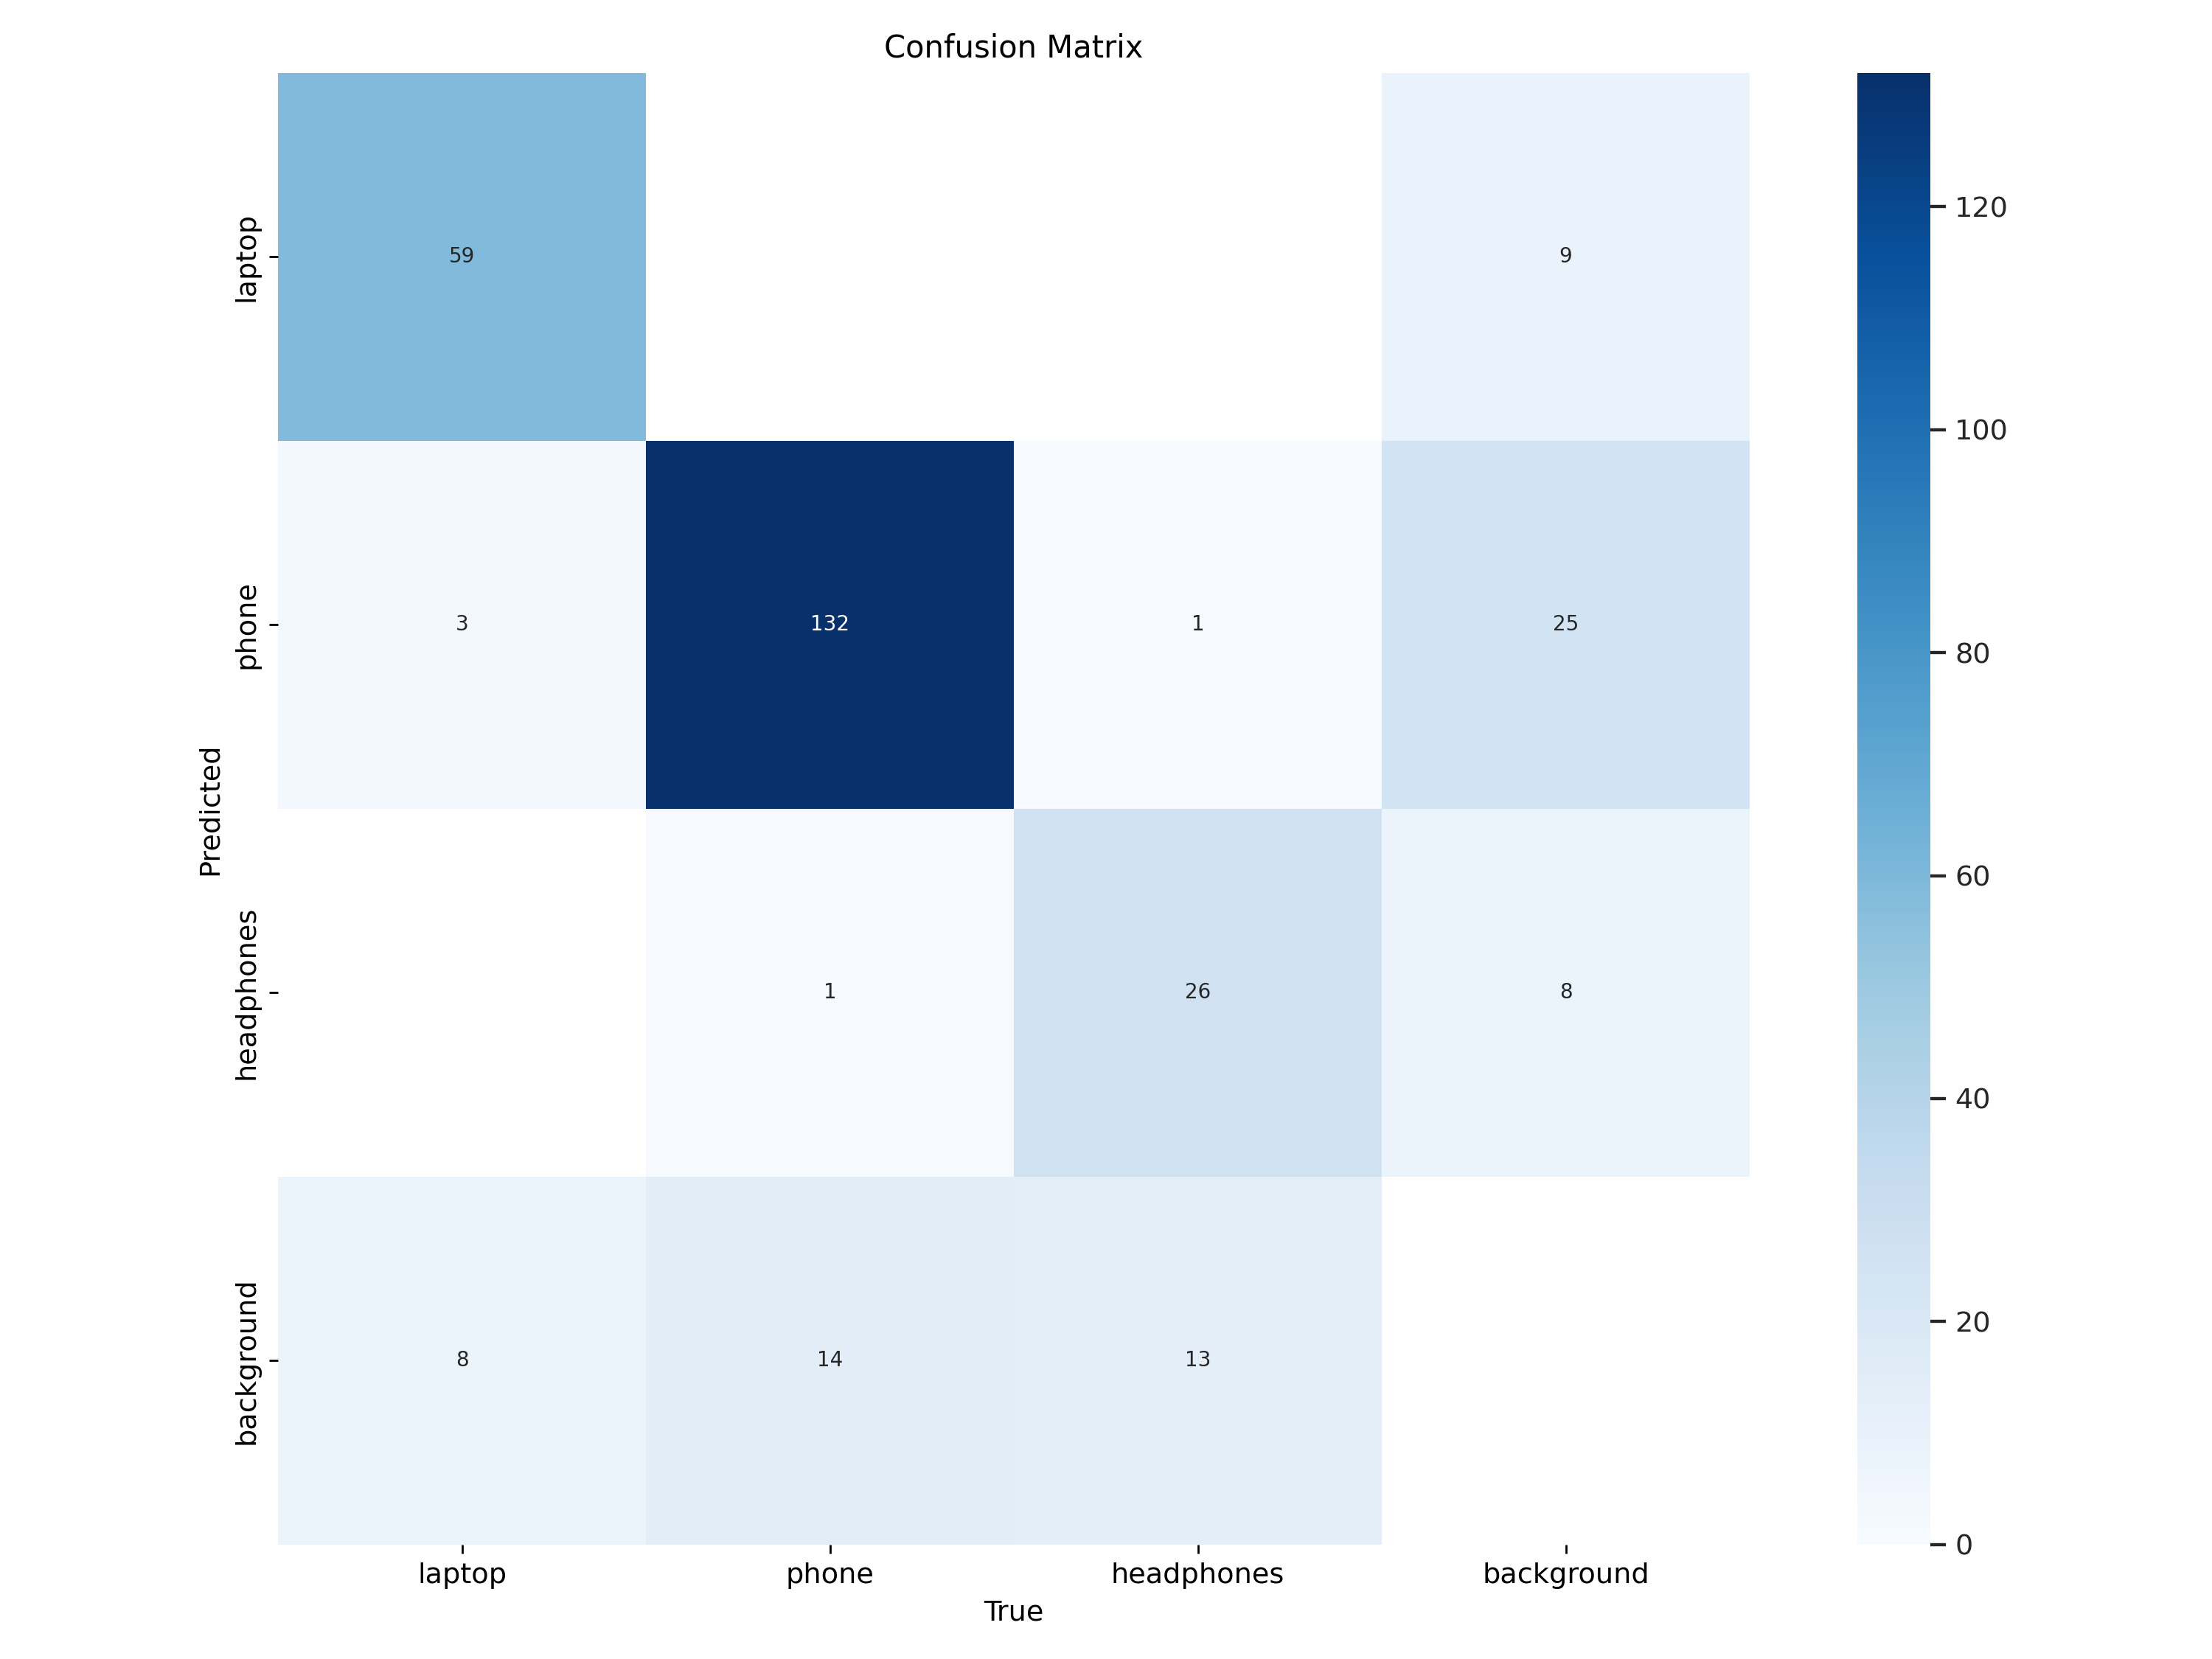

In [91]:
# Export out model to GDrive

from google.colab import drive
drive.mount('/content/drive')
! mkdir /content/drive/MyDrive/ML_YOLO_12Epochs
! cp /content/runs/detect/train/* /content/drive/MyDrive/ML_YOLO_12Epochs

from IPython.display import Image, display
display(Image('/content/drive/MyDrive/ML_YOLO_12Epochs/val_batch0_pred.jpg'))
display(Image('/content/drive/MyDrive/ML_YOLO_12Epochs/val_batch1_pred.jpg'))
display(Image('/content/drive/MyDrive/ML_YOLO_12Epochs/F1_curve.png'))
display(Image('/content/drive/MyDrive/ML_YOLO_12Epochs/results.png'))
display(Image('/content/drive/MyDrive/ML_YOLO_12Epochs/confusion_matrix.png'))

drive.flush_and_unmount()

# Success!